In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from dateutil.relativedelta import relativedelta

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
2016-08-23


<IPython.core.display.Javascript object>


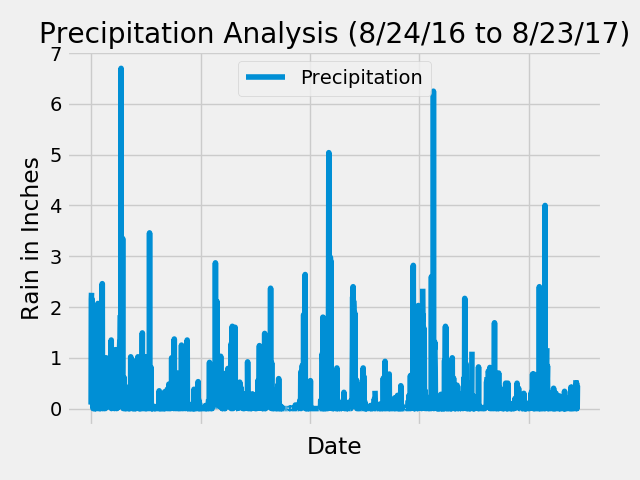

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

    
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])
    
conn = engine.connect()
data1 = pd.read_sql("SELECT * FROM Station", conn)
# Calculate the date 1 year ago from today

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

year_ago = dt.date(2017, 8, 23) - relativedelta(months=+12)
print(year_ago)

rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

rain_df = pd.DataFrame(rain, columns=['date', 'prcp'])

rain_df.head()
rain_df1 = rain_df.set_index('date')
rain_df1 
rain_df2 = rain_df1.sort_values(by='date')
rain_df2 

rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df2.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
locations
print("There are {} stations.".format(locations))

There are 9 stations.


In [12]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = [Measurement.station, 
       func.count(Measurement.tobs)]

active_stations1 = session.query(*active_stations).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()


print("The busiest stations in descending orders are:")
for station, count in active_stations1:
    print("Station", station, "with",count, "weather observations.")




The busiest stations in descending orders are:
Station USC00519281 with 2772 weather observations.
Station USC00519397 with 2724 weather observations.
Station USC00513117 with 2709 weather observations.
Station USC00519523 with 2669 weather observations.
Station USC00516128 with 2612 weather observations.
Station USC00514830 with 2202 weather observations.
Station USC00511918 with 1979 weather observations.
Station USC00517948 with 1372 weather observations.
Station USC00518838 with 511 weather observations.


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

stats = [func.avg(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs)]
temp_stats = session.query(*stats).filter(Measurement.station == 'USC00519281').all()
temp_stats


[(71.66378066378067, 85.0, 54.0)]

<IPython.core.display.Javascript object>


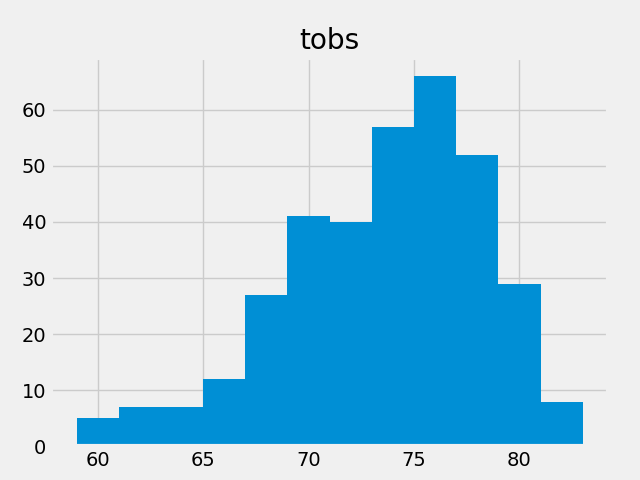

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

busy = session.query(Measurement.tobs).filter(Measurement.date > year_ago).filter(Measurement.station == 'USC00519281').all()

busy_df = pd.DataFrame(busy)

hist = busy_df.hist(bins=12)



In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2012, 2, 28)
trip_leave = dt.date(2012, 3, 5)
last_year = dt.timedelta(days=365)
avg_temp_last_year = calc_temps((trip_arrive-last_year), (trip_leave-last_year))
avg_temp_last_year


[(61.0, 70.08928571428571, 75.0)]

<IPython.core.display.Javascript object>


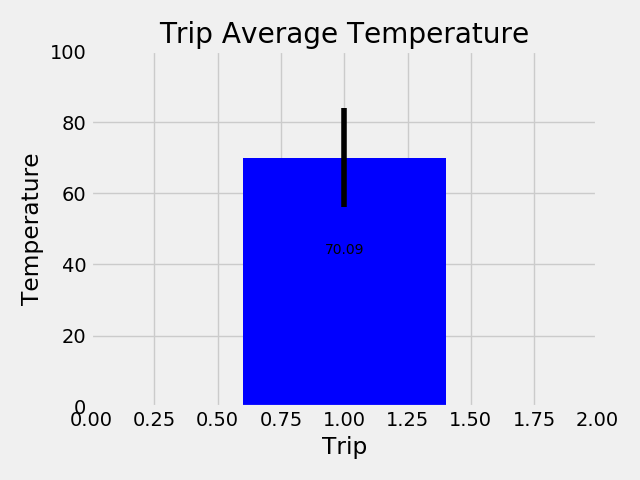

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = avg_temp_last_year[0][2]-avg_temp_last_year[0][0]
avgtemp = avg_temp_last_year[0][1]
min_temp = avg_temp_last_year[0][0]
max_temp = avg_temp_last_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'blue', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature")

autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

In [39]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    order_by(Measurement.station).all()


vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

test = rain_per_station.sort_values(['prcp'], ascending=[False])

test

2011-02-28
2011-03-06


,prcp
station,
USC00519281,3.74
USC00514830,2.60
USC00513117,2.60
USC00519523,2.46
USC00518838,2.33
USC00516128,1.69
USC00519397,1.41
USC00511918,0.63
USC00517948,0.00


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


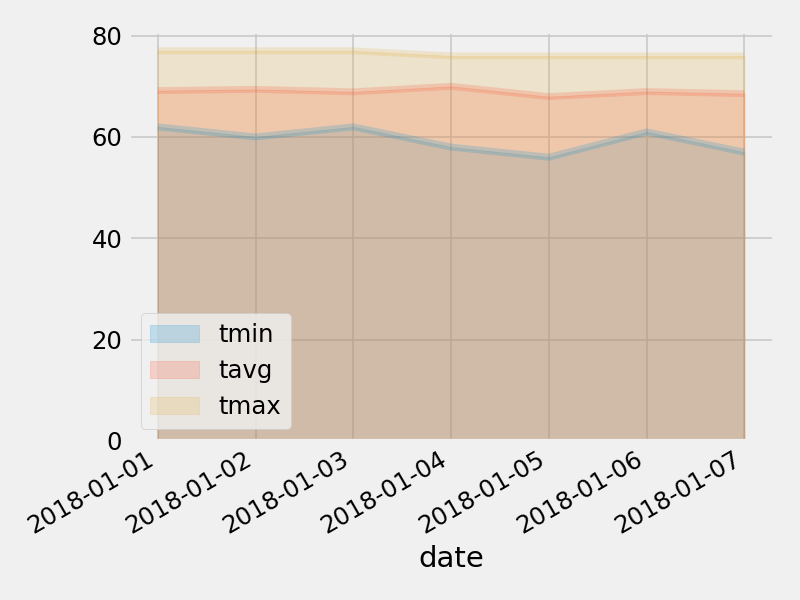

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
